In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from experiments.tensor_dist import tn_prob_dist as tnpd
from src.tt_eda.MPS_TN import MPS
from src.tt_eda.MPS_Opt import Opt_MPS

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 20,
    "legend.fontsize": 12,
    "axes.linewidth": 1.5,
})

# Function Optimization: Single-Site Gradient with 1-Norm Probabilities

In [2]:
from experiments.func.funcs_bench import func_build_ackley, func_build_alpine,func_build_rastrigin,func_build_griewank

function_builders = [func_build_alpine,func_build_ackley,func_build_rastrigin,func_build_griewank]

num_args = 7
n_grid_args= 11
chi = 3
base_seed = 571231 
tot_func_eval =2000 
num_samples = 30
num_elites = 5
learning_rate = 0.06 
num_sweeps =5 


all_results = {builder.__name__: {} for builder in function_builders}
rng_master = np.random.RandomState(base_seed)
for i, builder in enumerate(function_builders):
    target_function, func_domain_a, func_domain_b = builder(num_args, n_grid_args)
    run_seed = rng_master.randint(0, 2**32 - 1)

    # Setting up the proposal distribution in the form of an MPS (non-negative aka 1-Norm def. of probabilities)
    mps_init = MPS.uniform_pdf_MPS(length=num_args, phys_leg_dim=n_grid_args, const_chi=chi)
    
    # Setting up the optimizer for the proposal distribution
    optimizer= Opt_MPS(
        bbox_func=target_function,
        MPS_instance=mps_init,
        num_bbox_func_query=tot_func_eval,
        tot_num_samples=num_samples,
        num_top_samples=num_elites,
        learning_rate=learning_rate,
        num_sweeps=num_sweeps
    )
    func_name = builder.__name__
    print(f"Running optimization for function: {func_name} with seed {run_seed}")
    x_min_final, y_min_final, history = optimizer.opt_engine_weighted_stag(base_seed=run_seed)
    # x_min_final, y_min_final, history = optimizer.opt_engine(base_seed=run_seed)

    all_results[func_name].update({
        'y_final': y_min_final,
        'history': history
    })

    

Running optimization for function: func_build_alpine with seed 2662275735

--- Running Optimization (weighted, scheme=logrank) ---
    Budget M=2000, K=30, k=5
    Update params: lr=0.06, sweeps=5, mut=0.0
    Iter 1 [Evals 30/2000]: Best y_min = 1.252e+01  LL = 1.451e+01  mut=0.000
    Iter 2 [Evals 60/2000]: Best y_min = 9.636e+00  LL = 1.375e+01  mut=0.050
    Iter 3 [Evals 90/2000]: Best y_min = 9.333e+00  LL = 1.257e+01  mut=0.050
    Iter 4 [Evals 120/2000]: Best y_min = 6.922e+00  LL = 1.062e+01  mut=0.050
    Iter 5 [Evals 150/2000]: Best y_min = 4.848e+00  LL = 1.098e+01  mut=0.050
    Iter 6 [Evals 180/2000]: Best y_min = 3.772e+00  LL = 9.312e+00  mut=0.050
    Iter 8 [Evals 240/2000]: Best y_min = 2.695e+00  LL = 6.189e+00  mut=0.050
    Iter 9 [Evals 270/2000]: Best y_min = 2.153e+00  LL = 6.679e+00  mut=0.050
    Iter 10 [Evals 300/2000]: Best y_min = 0.000e+00  LL = 4.365e+00  mut=0.050
    Iter 15 [Evals 450/2000]: Best y_min = 0.000e+00  LL = 5.010e-01  mut=0.050
    I

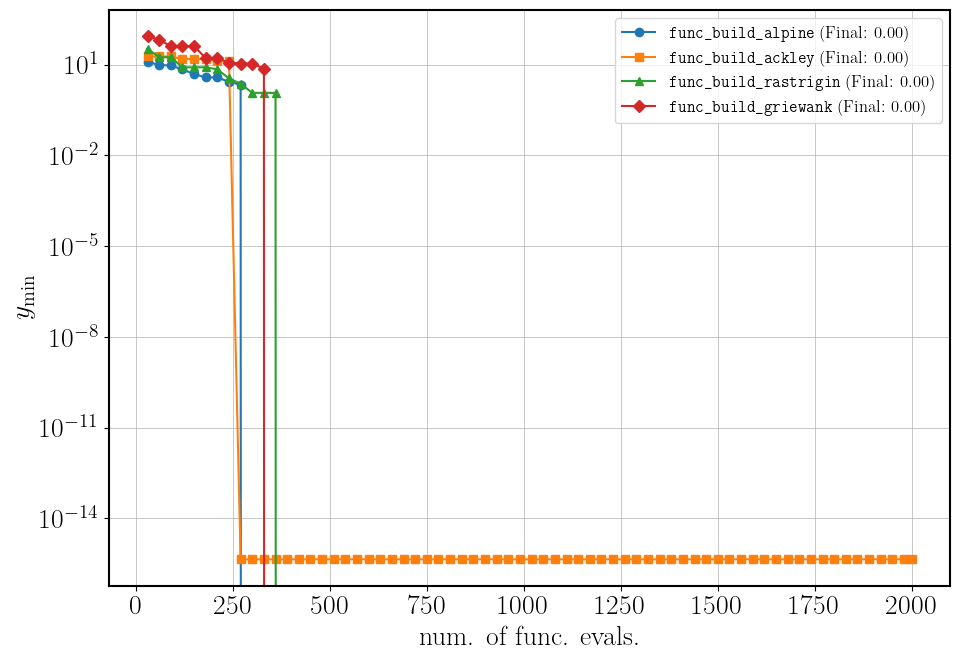

In [9]:
plt.figure(figsize=(10, 7))
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'X']
for i, (func_name, result) in enumerate(all_results.items()):
    hist = result['history']
    evals = np.array([item[0] for item in hist])
    y_best_hist = np.array([item[1] for item in hist])
    label_text = r'\texttt{' + func_name + '} (Final: ' + f"{result['y_final']:.2f})"
    plt.plot(
    evals, y_best_hist,
    marker=markers[i % len(markers)], linestyle='-',
    markersize=6, linewidth=1.5, label=label_text)
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.yscale('log')
    plt.xlabel('num. of func. evals.')
    plt.ylabel(r'$y_{\mathrm{min}}$')
    plt.legend()
plt.tight_layout()
plt.show()



# Function Optimization: Two-Site Gradient with 2-Norm Probabilities (Born machine approach)

In [106]:
from experiments.func.funcs_bench import func_build_ackley, func_build_alpine,func_build_rastrigin,func_build_griewank

function_builders = [func_build_alpine,func_build_ackley,func_build_rastrigin,func_build_griewank]

num_args = 7
n_grid_args= 11
chi = 3
base_seed = 571231 
tot_func_eval =2000 
num_samples = 50
num_elites = 5
learning_rate = 0.01 
num_sweeps =1 

all_results = {builder.__name__: {} for builder in function_builders}
rng_master = np.random.RandomState(base_seed)
for i, builder in enumerate(function_builders):
    target_function, func_domain_a, func_domain_b = builder(num_args, n_grid_args)
    run_seed = rng_master.randint(0, 2**32 - 1)

    # Setting up the proposal distribution in the form of an MPS (Born machine aka 2-Norm def. of probabilities)
    mps_init = MPS.uniform_Born_pdf_MPS(length=num_args, phys_leg_dim=n_grid_args, const_chi=chi)
    mps_init.make_R_canon()
    
    # Setting up the optimizer for the proposal distribution
    optimizer= Opt_MPS(
        bbox_func=target_function,
        MPS_instance=mps_init,
        num_bbox_func_query=tot_func_eval,
        tot_num_samples=num_samples,
        num_top_samples=num_elites,
        learning_rate=learning_rate,
        num_sweeps=num_sweeps,
        base_mutation_rate=0.065,
    )
    func_name = builder.__name__
    print(f"Running optimization for function: {func_name} with seed {run_seed}")
    x_min_final, y_min_final, history = optimizer.opt_engine_born(base_seed=run_seed)
    all_results[func_name].update({
        'y_final': y_min_final,
        'history': history
    })

    

Running optimization for function: func_build_alpine with seed 2662275735

--- Running Optimization (EDA-like with Stagnation Response) ---
    Budget M=2000, K=50, k_update=5
    Update params: lr=0.01, sweeps=1
    Stagnation: Patience=10, ActiveMutation=0.05, PerturbStrength=0.05
normal or not [[1.]]
    Iter 1 [Evals 50/2000]: Best y_min = 9.617e+00  NLL_Loss = 4.0659 Mut=0.07
normal or not [[1.]]
    Iter 4 [Evals 200/2000]: Best y_min = 8.448e+00  NLL_Loss = 2.4905 Mut=0.07
normal or not [[1.]]
    Iter 5 [Evals 250/2000]: Best y_min = 8.448e+00  NLL_Loss = 1.5724 Mut=0.07
normal or not [[1.]]
    Iter 6 [Evals 300/2000]: Best y_min = 7.790e+00  NLL_Loss = 1.1736 Mut=0.07
normal or not [[1.]]
    Iter 7 [Evals 350/2000]: Best y_min = 7.132e+00  NLL_Loss = 2.2617 Mut=0.07
normal or not [[1.]]
    Iter 8 [Evals 400/2000]: Best y_min = 5.514e+00  NLL_Loss = 1.8794 Mut=0.07
normal or not [[1.]]
    Iter 9 [Evals 450/2000]: Best y_min = 3.895e+00  NLL_Loss = 3.3040 Mut=0.07
normal or 

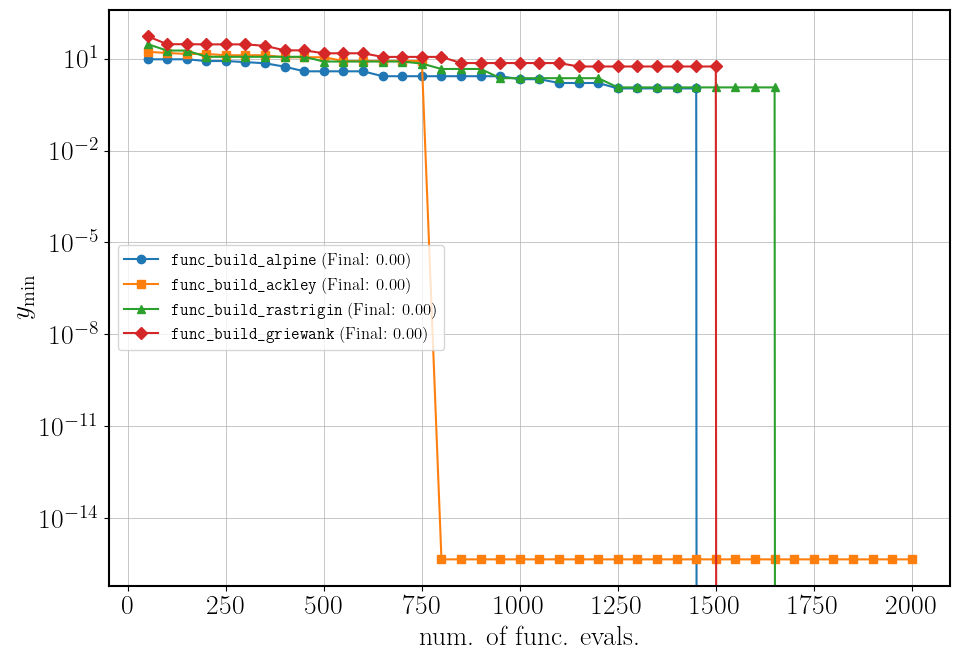

In [107]:
plt.figure(figsize=(10, 7))
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'X']
for i, (func_name, result) in enumerate(all_results.items()):
    hist = result['history']
    evals = np.array([item[0] for item in hist])
    y_best_hist = np.array([item[1] for item in hist])
    label_text = r'\texttt{' + func_name + '} (Final: ' + f"{result['y_final']:.2f})"
    plt.plot(
    evals, y_best_hist,
    marker=markers[i % len(markers)], linestyle='-',
    markersize=6, linewidth=1.5, label=label_text)
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.yscale('log')
    plt.xlabel('num. of func. evals.')
    plt.ylabel(r'$y_{\mathrm{min}}$')
    plt.legend()
plt.tight_layout()
plt.show()
